# Imports

In [1]:
from __future__ import print_function, division
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import math
import operator
import numpy as np
import pandas as pd
import pickle as pkl
import tifffile as tif
import matplotlib.pyplot as plt
from multiprocessing import Pool
from sklearn.utils import shuffle
from keras import layers
from keras import models
from keras.utils import Sequence
from keras.layers import LeakyReLU
from keras.models import load_model, save_model
from keras.utils.vis_utils import plot_model
from livelossplot import PlotLossesKeras

# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F
# from torchvision import transforms, utils
# from torch.utils.data import Dataset, DataLoader
os.chdir("../../")

Using TensorFlow backend.


# Data Preprocessing

### Class Declaration

In [2]:
class Data_Preprocess():
    
    def init_load(self, root_dir, csv_file):
        self.df = pd.read_csv(csv_file, low_memory=False)
        self.path = root_dir
    
    def create_mappings_for_unique_labels(self):
        # getting all unique names from csv file
        self.classes = list(sorted(self.df['class'].unique()))
        self.orders = list(sorted(self.df['order'].unique()))
        self.family = list(sorted(self.df['family'].unique()))
        self.genus = list(sorted(self.df['genus'].unique()))
        self.species = list(sorted(self.df['species_glc_id'].unique()))
        self.all_names = self.classes + self.orders + self.family + self.genus + self.species
        # creting map for one hot encoding / embedding
        self.all_encoded = {}
        self.all_rev_encoded = {}
        
        for i, name in enumerate(self.all_names):
            self.all_encoded[str(name)] = i
            self.all_rev_encoded[int(i)] = str(name)
        
        self.embeddings = pkl.load(open("Data/final_embeddings.pkl","rb"), encoding='latin')
        
        
    def train_test_data_loading(self):
        self.x_train, self.x_test, self.y_train, self.y_test = [], [], [], []
        for cls in self.df['class'].unique():
                for order in self.df[self.df['class']==cls]['order'].unique():
                    for family in self.df[(self.df['class']==cls) & (self.df['order']==order)]['family'].unique():
                        for genus in self.df[(self.df['class']==cls) & (self.df['order']==order) & (self.df['family']==family)]['genus'].unique():
                            for species in self.df[(self.df['class']==cls) & (self.df['order']==order) & (self.df['family']==family) & (self.df['genus']==genus)]['species_glc_id'].unique():
                                path = self.path+"train/"+cls+"/"+order+"/"+family+"/"+genus+"/"+str(species)+"/"
                                self.x_train.extend([path+i for i in os.listdir(path)])
                                path = self.path+"test/"+cls+"/"+order+"/"+family+"/"+genus+"/"+str(species)+"/"
                                self.x_test.extend([path+i for i in os.listdir(path)])
        
        np.random.shuffle(self.x_train)
        np.random.shuffle(self.x_test)
        
        for im in self.x_train:
            l = im.split("/")
            #c, o, f, g, s = self.all_encoded[l[3]], self.all_encoded[l[4]], self.all_encoded[l[5]], self.all_encoded[l[6]], self.all_encoded[l[7]]
            c, o, f, g, s = self.embeddings[l[3]], self.embeddings[l[4]], self.embeddings[l[5]], self.embeddings[l[6]], self.embeddings[l[7]]
            self.y_train.append([c,o,f,g,s])
            
        for im in self.x_test:
            l = im.split("/")
            #c, o, f, g, s = self.all_encoded[l[3]], self.all_encoded[l[4]], self.all_encoded[l[5]], self.all_encoded[l[6]], self.all_encoded[l[7]] #self.embed_vectors1['class'][self.all_encoded[l[3]]], self.embed_vectors1['order'][self.all_encoded[l[4]]], self.embed_vectors1['family'][self.all_encoded[l[5]]], self.embed_vectors1['genus'][self.all_encoded[l[6]]], self.embed_vectors2['species_glc_id'][int(l[7])]
            c, o, f, g, s = self.embeddings[l[3]], self.embeddings[l[4]], self.embeddings[l[5]], self.embeddings[l[6]], self.embeddings[l[7]]
            self.y_test.append([c,o,f,g,s])
        
    def ordered_call(self, root_dir, csv_file):
        print("Creating the data preprocessing object and loading csv")
        self.init_load(root_dir, csv_file)
        print("Creating unique mappings for labels")
        self.create_mappings_for_unique_labels()
        print("Loading test and train image paths and corresponding labels")
        self.train_test_data_loading()

### Implement data preprocessing

In [3]:
data = Data_Preprocess()

In [4]:
data.ordered_call(root_dir="Data/Hierarchial Data/", csv_file="occurrences_train.csv")

Creating the data preprocessing object and loading csv
Creating unique mappings for labels
Loading test and train image paths and corresponding labels


In [5]:
#data.y_train, data.y_test = np.array(data.y_train).reshape(-1,1), np.array(data.y_test).reshape(-1,1)
data.x_train, data.y_train, data.x_test, data.y_test = np.array(data.x_train), np.array(data.y_train), np.array(data.x_test), np.array(data.y_test)

In [6]:
data.y_test

array([[[-1.05134034e-02,  1.06065929e-01, -3.18392647e-02,
         -1.99240266e-01,  3.80888234e-02],
        [ 9.49251685e-02, -6.51749090e-02, -4.11850908e-02,
          1.51737924e-03, -9.19578598e-02],
        [ 2.85260368e-02,  4.14195009e-02, -3.50772406e-02,
          1.82968883e-02,  1.50176267e-02],
        [-6.26163433e-02,  4.11179238e-02, -2.20528471e-02,
          3.48961427e-02, -5.54268016e-02],
        [ 6.30192494e-02, -9.13808387e-02, -9.09741953e-02,
          3.53656241e-03,  1.33301034e-01]],

       [[ 2.33425382e-02, -2.62429460e-02, -1.76659062e-02,
         -2.97370796e-02, -2.38835575e-03],
        [ 1.96532981e-02, -7.19142358e-02,  1.13055835e-01,
         -9.56939862e-02,  1.20781706e-02],
        [-2.35086113e-02,  7.45222091e-02,  3.69890167e-02,
         -4.23056125e-02, -3.71842197e-02],
        [-9.24005393e-02,  1.33338639e-02,  5.39453765e-02,
          4.42819270e-02,  3.39952858e-02],
        [ 7.00699678e-03,  1.75830705e-01,  2.89824504e-04,
  

# Model

### Class Declaration

In [7]:
class CNN_Model:
    
    def __init__(self, data_object):
        self.img_height = 64
        self.img_width = 64
        self.img_channels = 53
        self.cardinality = 32
        self.data_object = data_object
        self.num_classes = len(data_object.all_encoded.keys())
    
    def residual_network(self, x):
        """
        ResNeXt by default. For ResNet set `cardinality` = 1 above.

        """
        def add_common_layers(y):
            y = layers.BatchNormalization()(y)
            y = layers.LeakyReLU()(y)

            return y

        def grouped_convolution(y, nb_channels, _strides):
            # when `cardinality` == 1 this is just a standard convolution
            if self.cardinality == 1:
                return layers.Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)

            assert not nb_channels % self.cardinality
            _d = nb_channels // self.cardinality

            # in a grouped convolution layer, input and output channels are divided into `cardinality` groups,
            # and convolutions are separately performed within each group
            groups = []
            for j in range(self.cardinality):
                group = layers.Lambda(lambda z: z[:, :, :, j * _d:j * _d + _d])(y)
                groups.append(layers.Conv2D(_d, kernel_size=(3, 3), strides=_strides, padding='same')(group))

            # the grouped convolutional layer concatenates them as the outputs of the layer
            y = layers.concatenate(groups)

            return y

        def residual_block(y, nb_channels_in, nb_channels_out, _strides=(1, 1), _project_shortcut=False):
            """
            Our network consists of a stack of residual blocks. These blocks have the same topology,
            and are subject to two simple rules:
            - If producing spatial maps of the same size, the blocks share the same hyper-parameters (width and filter sizes).
            - Each time the spatial map is down-sampled by a factor of 2, the width of the blocks is multiplied by a factor of 2.
            """
            shortcut = y

            # we modify the residual building block as a bottleneck design to make the network more economical
            y = layers.Conv2D(nb_channels_in, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
            y = add_common_layers(y)

            # ResNeXt (identical to ResNet when `cardinality` == 1)
            y = grouped_convolution(y, nb_channels_in, _strides=_strides)
            y = add_common_layers(y)

            y = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
            # batch normalization is employed after aggregating the transformations and before adding to the shortcut
            y = layers.BatchNormalization()(y)

            # identity shortcuts used directly when the input and output are of the same dimensions
            if _project_shortcut or _strides != (1, 1):
                # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
                # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
                shortcut = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
                shortcut = layers.BatchNormalization()(shortcut)

            y = layers.add([shortcut, y])

            # relu is performed right after each batch normalization,
            # expect for the output of the block where relu is performed after the adding to the shortcut
            y = layers.LeakyReLU()(y)

            return y

        # conv1
        x = layers.Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same')(x)
        x = add_common_layers(x)

        # conv2
        x = layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
        for i in range(3):
            project_shortcut = True if i == 0 else False
            x = residual_block(x, 128, 256, _project_shortcut=project_shortcut)

        # conv3
        for i in range(4):
            # down-sampling is performed by conv3_1, conv4_1, and conv5_1 with a stride of 2
            strides = (2, 2) if i == 0 else (1, 1)
            x = residual_block(x, 256, 512, _strides=strides)

        # conv4
        for i in range(6):
            strides = (2, 2) if i == 0 else (1, 1)
            x = residual_block(x, 512, 1024, _strides=strides)

        # conv5
        for i in range(3):
            strides = (2, 2) if i == 0 else (1, 1)
            x = residual_block(x, 1024, 2048, _strides=strides)

        x = layers.GlobalAveragePooling2D()(x)
        
        x = layers.RepeatVector(5)(x)
        x = layers.LSTM(256, return_sequences=True)(x)
        x = layers.TimeDistributed(layers.Dense(128))(x)
        x = layers.TimeDistributed(layers.Dense(5))(x)

        return x

    def model_create(self, time_steps, batch_size):
        image_tensor = layers.Input(shape=(self.img_height, self.img_width, self.img_channels))
        network_output = self.residual_network(image_tensor)  
        model = models.Model(inputs=[image_tensor], outputs=[network_output])
        print(model.summary())
        # Compiling the CNN
        model.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy','mae'])
        return model
    
    def fit_generator(self, num_epochs=10, batch_size=32, crop_size=16, time_steps=5):        
        try:
            classifier = load_model("Code/Models/CNN_LSTM_Embedded_ResNext2.h5")
        except:
            print("Training")
            classifier = self.model_create(time_steps=time_steps, batch_size=batch_size)
            train_data = ImageDataGenerator(self.data_object.x_train, self.data_object.y_train, batch_size, crop_size)
            #test_data = ImageDataGenerator(self.data_object.x_test, self.data_object.y_test, batch_size, crop_size)
            history = classifier.fit_generator(train_data, epochs=num_epochs, use_multiprocessing=True,shuffle=True)
            return classifier
            #Error saving the file.
            classifier.save("Code/Models/CNN_LSTM_Embedded_ResNext2.h5")
        print("Testing")
        test_data = ImageDataGenerator(self.data_object.x_test, self.data_object.y_test, batch_size, crop_size)
        scores = classifier.evaluate_generator(test_data, use_multiprocessing=True)
        print("Loss : ", scores[0])
        print("Metrics : ", scores[1:])
        return classifier

In [8]:
class ImageDataGenerator(Sequence):
    
    def __init__(self, x_metadata, y_metadata, batch_size, crop_size):
        self.x = x_metadata
        self.y = y_metadata
        self.batch_size = batch_size
        self.cp = crop_size
        self.dic = {0:[0,120,165,210],1:[35,62,85],2:[7,22,50],3:[0,1,2,3,4],4:[20,60,140],5:[60,100],6:[0,1,2,3,4],7:[1,2,4,8],8:[1,2],9:[0,1,2,3,4]}
        self.conv_dic = {0:[133,1176],1:[-10.00984,18.36730],2:[7.846126,20.94560],3:[41.182110,59.95573],4:[302.772980,777.74048],5:[6.182446,36.54550],6:[-28.248663,5.33183],7:[16.744829,41.94211],8:[-14.122952,22.96798],9:[-17.672335,26.44534],10:[-2.738379,26.44534],11:[-17.672335,11.73241],12:[318.297485,2543.30225],13:[43.063732,285.43790],14:[3.022581,135.58406],15:[8.283675,57.78888],16:[121.616867,855.52594],17:[19.868601,421.27750],18:[19.868601,851.60620],19:[60.590000,520.31244],20:[-187.999999,4672.000000]}
    
    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))
    
    def binarization(self,image,un):
        img = np.zeros((64,64,len(un)))
        for i in range(len(un)):
            img[:,:,i] = (image.copy())
            img[:,:,i][img[:,:,i] != un[i]] = 0
        return img   
    
    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        x = []
        for i in range(len(batch_x)):
            tempf = tif.imread(batch_x[i])[:21,:,:]
            for k in range(21):
                tempf[k] = self.conv_dic[k][0] + (self.conv_dic[k][1] - self.conv_dic[k][0]) * ((tempf[k]/255.0) - 0.1) / 0.8
            tempf = np.transpose(tempf,(1,2,0))
            
            l = []
            temp = tif.imread(batch_x[i])[21:,:,:]
            for k in range(10):
                un = np.array(self.dic[k])
                un = un[un != 0]
                img=np.transpose(self.binarization(temp[k],un),(2,0,1)).tolist()
                l.extend(img)
            x.append(np.concatenate((tempf,np.transpose(np.array(l),(1,2,0))), axis=2))
        return np.array(x), np.array(batch_y)

### Model Run

In [9]:
model_object = CNN_Model(data)
model = model_object.model_create(5,32)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 53)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   166272      input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 32, 32, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

lambda_235 (Lambda)             (None, 8, 8, 16)     0           leaky_re_lu_23[0][0]             
__________________________________________________________________________________________________
lambda_236 (Lambda)             (None, 8, 8, 16)     0           leaky_re_lu_23[0][0]             
__________________________________________________________________________________________________
lambda_237 (Lambda)             (None, 8, 8, 16)     0           leaky_re_lu_23[0][0]             
__________________________________________________________________________________________________
lambda_238 (Lambda)             (None, 8, 8, 16)     0           leaky_re_lu_23[0][0]             
__________________________________________________________________________________________________
lambda_239 (Lambda)             (None, 8, 8, 16)     0           leaky_re_lu_23[0][0]             
__________________________________________________________________________________________________
lambda_240

lambda_496 (Lambda)             (None, 2, 2, 32)     0           leaky_re_lu_47[0][0]             
__________________________________________________________________________________________________
lambda_497 (Lambda)             (None, 2, 2, 32)     0           leaky_re_lu_47[0][0]             
__________________________________________________________________________________________________
lambda_498 (Lambda)             (None, 2, 2, 32)     0           leaky_re_lu_47[0][0]             
__________________________________________________________________________________________________
lambda_499 (Lambda)             (None, 2, 2, 32)     0           leaky_re_lu_47[0][0]             
__________________________________________________________________________________________________
lambda_500 (Lambda)             (None, 2, 2, 32)     0           leaky_re_lu_47[0][0]             
__________________________________________________________________________________________________
lambda_501

In [11]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

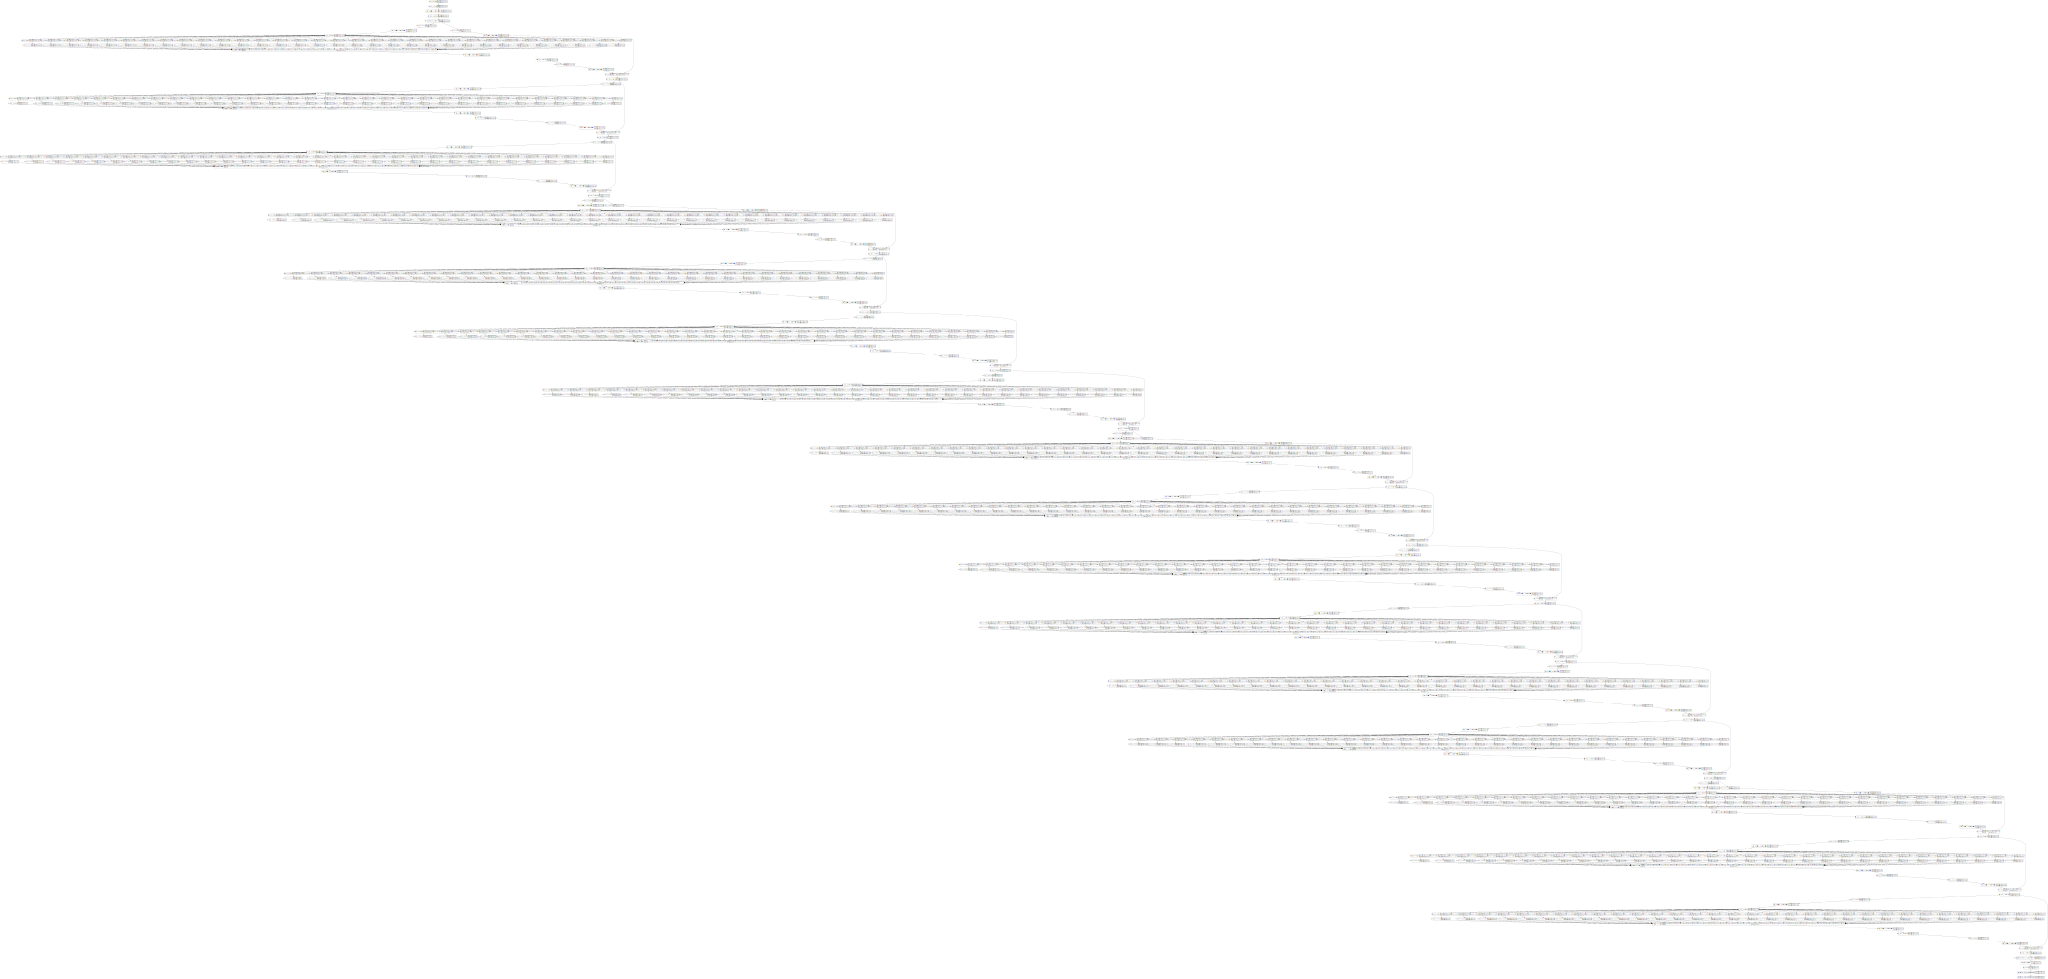

In [10]:
import IPython,keras

IPython.display.SVG(keras.utils.vis_utils.model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [9]:
classifier = model_object.fit_generator(num_epochs=1, batch_size=32, crop_size=32)

Training
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 53)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   166272      input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 32, 32, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
m

lambda_211 (Lambda)             (None, 8, 8, 8)      0           leaky_re_lu_20[0][0]             
__________________________________________________________________________________________________
lambda_212 (Lambda)             (None, 8, 8, 8)      0           leaky_re_lu_20[0][0]             
__________________________________________________________________________________________________
lambda_213 (Lambda)             (None, 8, 8, 8)      0           leaky_re_lu_20[0][0]             
__________________________________________________________________________________________________
lambda_214 (Lambda)             (None, 8, 8, 8)      0           leaky_re_lu_20[0][0]             
__________________________________________________________________________________________________
lambda_215 (Lambda)             (None, 8, 8, 8)      0           leaky_re_lu_20[0][0]             
__________________________________________________________________________________________________
lambda_216

__________________________________________________________________________________________________
leaky_re_lu_41 (LeakyReLU)      (None, 4, 4, 1024)   0           batch_normalization_44[0][0]     
__________________________________________________________________________________________________
lambda_417 (Lambda)             (None, 4, 4, 32)     0           leaky_re_lu_41[0][0]             
__________________________________________________________________________________________________
lambda_418 (Lambda)             (None, 4, 4, 32)     0           leaky_re_lu_41[0][0]             
__________________________________________________________________________________________________
lambda_419 (Lambda)             (None, 4, 4, 32)     0           leaky_re_lu_41[0][0]             
__________________________________________________________________________________________________
lambda_420 (Lambda)             (None, 4, 4, 32)     0           leaky_re_lu_41[0][0]             
__________

Epoch 1/1
4781/4781 [==============================] - 10445s 2s/step - loss: 0.0052 - acc: 0.3642 - mean_absolute_error: 0.0464


In [15]:
classifier

In [13]:
t

2

In [19]:
test_data = ImageDataGenerator(data.x_test, data.y_test,32,32)
scores = classifier.evaluate_generator(test_data, use_multiprocessing=True)

In [20]:
scores

[0.003361604392853601, 0.3914189404358922, 0.044600772543996831]

In [10]:
 classifier.save("Code/Models/RCNN_ResNext_Latest.h5")

RuntimeError: Unable to create attribute (Object header message is too large)

In [18]:
# serialize model to JSON
model_json = classifier.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
classifier.save_weights("Code/Models/RCNN_ResNext_Latest.h5")
print("Saved model to disk")

Saved model to disk


In [16]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("Code/Models/RCNN_ResNext_Latest.h5")
print("Loaded model from disk")

FileNotFoundError: [Errno 2] No such file or directory: 'model.json'